<a href="https://colab.research.google.com/github/Donovanphenry/Hide_And_Seq/blob/main/Hide_And_Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Debug Notice: Find and Squash all `#TODO` mentions!

## Installing Required Libraries

In [1]:
# installs and magics
!pip install Bio
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from Bio import SeqIO
import pandas as pd
import numpy as np
import math
# import random

# clear import log garbage
clear_output()

## Download dataset

In [2]:
# downloading dataset
!wget --user=ftp ftp://ccg.epfl.ch/epd/current/epd_16K.seq
clear_output()

## Building DataFrames

## Set seeds

In [3]:
np.random.seed(0)

### Function to generate negative dataset

In [4]:
# generate negative dataset 

def gen_neg_dataset(sequence_string):    
  # create 400 subdivisions 
  to_numpy = np.array(list(sequence_string))
  spliced_sequence_array = np.split(to_numpy, 20)
  
  # randomly select 240 subvisions of the 
  # TODO: Make the random shuffle unique
  for i in range(12):
    k = np.random.randint(0, 19)

    # shuffle contents of randomly chosen subvision
    np.random.shuffle(spliced_sequence_array[k])
  
  neg_sequence = ''

  for i in range(20):
    for k in range(15):
      neg_sequence += spliced_sequence_array[i][k]

  return neg_sequence

### Parsing the dataset

In [5]:
# Initializing lists that will contain info about each record
DNA_Sequences = []
sequence_lengths = []
parsed_subsequences = []
neg_subsequences = []
windowed_sequence_list = []
neg_windowed_sequence_list = []

# defining one-hot encoding for each nucleotide base 
dna_mappings = {}
dna_mappings['A'] = [0, 0, 0, 1]
dna_mappings['C'] = [0, 0, 1, 0]
dna_mappings['T'] = [0, 1, 0, 0]
dna_mappings['G'] = [1, 0, 0, 0]
# dna_mappings['A'] = 1
# dna_mappings['C'] = 10
# dna_mappings['T'] = 100
# dna_mappings['G'] = 1000

# All DNA sequences of the human genome are 16,000 characters long (Hence epd_16K)
# if using epd_16K. If using epd_seq, then change the sequence_length variable
# to 600
sequence_length = 16000

# Loop through all records parsed by SeqIO.
#
# ") Hs" on the description line means that
# we've found a Homo sapien DNA sequence, so
# add the appropriate properties of seq_record
# to the appropriate arrays. This is our way
# to filter out non-homosapien sequences
for seq_record in SeqIO.parse('epd_16K.seq', 'fasta'):
  # -1 is returned if sequence is NOT found
  if seq_record.seq.find('N') == -1: # and seq_record.description.find(') Hs') != -1:
    DNA_Sequences.append(seq_record.seq)
    sequence_lengths.append(len(seq_record))

print("Number of sequences: " + str(len(DNA_Sequences)))

Number of sequences: 4140


## Encoding Dataset & Neg-Dataset & Calculating Position Specific Frequency Matrix information

$$
index_{promoter} = 10,000\\
Current:\\
spliced_{start_1} = index_{promoter} - length_{sequence_1} + (\frac{1}{6})length_{sequence_1} = 10,000 - 6,000 + 1,000 = 5,000 \\
spliced_{end_1} = spliced_{start_1} + (\frac{2}{3})length_{sequence_1} = 9,000\\
length_{sequence_1} = 6,000\\
\\
Want:\\
spliced_{start_2} = index_{promoter} - length_{sequence_2} + (\frac{1}{6})length_{sequence_2} = 10,000 - 300 + (\frac{1}{6})300 = 9,750\\
spliced_{end_2} = spliced_{start_2} + (\frac{2}{3})length_{sequence_2} = 9,950\\
length_{sequence_2} = 300\\
$$

In [6]:
# calculate PSFM of nucleotides for sequences

# Defining rows of PSFM and initializing all frequencies to 0
adenine_frequencies = np.zeros(sequence_length)
guanine_frequencies = np.zeros(sequence_length)
thymine_frequencies = np.zeros(sequence_length)
cytosine_frequencies = np.zeros(sequence_length)
other_frequency = np.zeros(sequence_length)

# Loop through all the DNA sequences in the DNA_Sequence list.
# For each sequence, check if the nucleobase (character) at 
# postition sequence_index is adenine, guanine, thymine, or cytosine.
# If it's any of those, then increment the count at that list's index.
i = 0
for sequence in DNA_Sequences:

  # Randomly generating where the window begins,
  # and since we want each sequence to be 6,000 chars
  # long, we add 6,000 to the rng splicedStart, giving
  # us the spliced end. Then, since we moved the start of
  # the sequence up by a number of splicedStart, to get where
  # the promoter is in relation to that new start, we can
  # subtract splicedStart from 10,000
  # i.e. promoterindex = 10,000 - splicedStart

  # TODO: seed the random number generator to consistently generate "random" negative dataset
  i += 1

  splicedStart = np.random.randint(9750, 9950)
  splicedEnd = splicedStart + 300
  sub_sequence = sequence[splicedStart : splicedEnd]
  promoter_index = 10000 - splicedStart
  
  neg_sub_sequence = gen_neg_dataset(str(sub_sequence))

  if str(sub_sequence) == neg_sub_sequence:
    print('Same sequence')

  encoding = []
#   encoding.append(promoter_index)

  neg_encoding = []
  

  for nucleotide in sub_sequence:
    encoding.extend(dna_mappings[nucleotide])

  np_encoding = np.array(encoding)
  a_channel = np_encoding[3:-1:4]
  c_channel = np_encoding[2:-2:4]
  t_channel = np_encoding[1:-3:4]
  g_channel = np_encoding[0:-4:4]

  seq_info = []
  seq_info.append(promoter_index)
  seq_info.append(a_channel)
  seq_info.append(c_channel)
  seq_info.append(t_channel)
  seq_info.append(g_channel)

  
  for nucleotide in neg_sub_sequence:
    neg_encoding.extend(dna_mappings[nucleotide])

  np_neg_encoding = np.array(neg_encoding).astype('float32')
  a_channel = np_neg_encoding[3:-1:4]
  c_channel = np_neg_encoding[2:-2:4]
  t_channel = np_neg_encoding[1:-3:4]
  g_channel = np_neg_encoding[0:-4:4]

  neg_seq_info = []
  neg_seq_info.append('x')
  neg_seq_info.append(a_channel)
  neg_seq_info.append(c_channel)
  neg_seq_info.append(t_channel)
  neg_seq_info.append(g_channel)
  
  windowed_sequence_list.append((promoter_index, np_encoding))
  neg_windowed_sequence_list.append(('x', np_neg_encoding))
  
  pair = (sub_sequence, promoter_index, splicedStart, splicedEnd)
  parsed_subsequences.append(pair)  

  # Reset where the index is in the
  # sequence string
  sequence_index = 0

  for nucleobase in sequence:
    if nucleobase == 'A':
      adenine_frequencies[sequence_index] += 1
    elif nucleobase == 'G':
      guanine_frequencies[sequence_index] += 1
    elif nucleobase == 'T':
      thymine_frequencies[sequence_index] += 1
    elif nucleobase == 'C':
      cytosine_frequencies[sequence_index] += 1
    else:
      other_frequency[sequence_index] += 1

    sequence_index += 1
  
dna_df_columns = []
dna_df_columns.append('Promoter-Index')
# dna_df_columns.append('A Channel')
# dna_df_columns.append('C Channel')
# dna_df_columns.append('T Channel')
# dna_df_columns.append('G Channel')
dna_df_columns.append('One Hot Sequence')

neg_dna_df_columns = []
neg_dna_df_columns.append('Promoter-Index')
# neg_dna_df_columns.append('A Channel')
# neg_dna_df_columns.append('C Channel')
# neg_dna_df_columns.append('T Channel')
# neg_dna_df_columns.append('G Channel')
neg_dna_df_columns.append('One Hot Sequence')

# for i in range(300):
#   for k in range(4):
    # dna_df_columns.append("Nuc(" + str(i) + ", " + str(k) + ")")
    # neg_dna_df_columns.append("Nuc(" + str(i) + ", " + str(k) + ")")

# these lines are taking a long time to execute?
dna_df = pd.DataFrame(windowed_sequence_list, columns = dna_df_columns)
neg_dna_df = pd.DataFrame(neg_windowed_sequence_list, columns = neg_dna_df_columns)

subsequence_df = pd.DataFrame(parsed_subsequences, columns = ['Sub-Sequences', 'Promoter-Index', 'SequenceStart', 'SequenceEnd'])

# In the above loop, we calculated how many occurences M of a particular nucelobase N
# at some sequence index I. In this loop, we divide each number of occurences by the total
# number of possible occurences there could be, which would be the number of records
# because each record is guaranteed to have a nucleobase at character I in the human
# DNA sequence. I.e.
# P(sequence[i] == N) == (# of nucleobases N found at index i) / (# of possible nucleobases N at index i)
for i in range(sequence_length):
  adenine_frequencies[i] = (adenine_frequencies[i] / len(DNA_Sequences)) * 100
  guanine_frequencies[i] = (guanine_frequencies[i] / len(DNA_Sequences)) * 100
  thymine_frequencies[i] = (thymine_frequencies[i] / len(DNA_Sequences)) * 100
  cytosine_frequencies[i] = (cytosine_frequencies[i] / len(DNA_Sequences)) * 100

# Defining the data frame for the Position Specific Frequency Matrix (PSFM)
frequency_df = pd.DataFrame({'Adenine Frequencies': adenine_frequencies, 'Guanine Frequencies': guanine_frequencies, 'Thymine Frequencies': thymine_frequencies, 'Cytosine Frequencies': cytosine_frequencies},
                            columns = ['Adenine Frequencies', 'Guanine Frequencies', 'Thymine Frequencies', 'Cytosine Frequencies'])

## Plotting frequency graph

<Figure size 432x288 with 0 Axes>

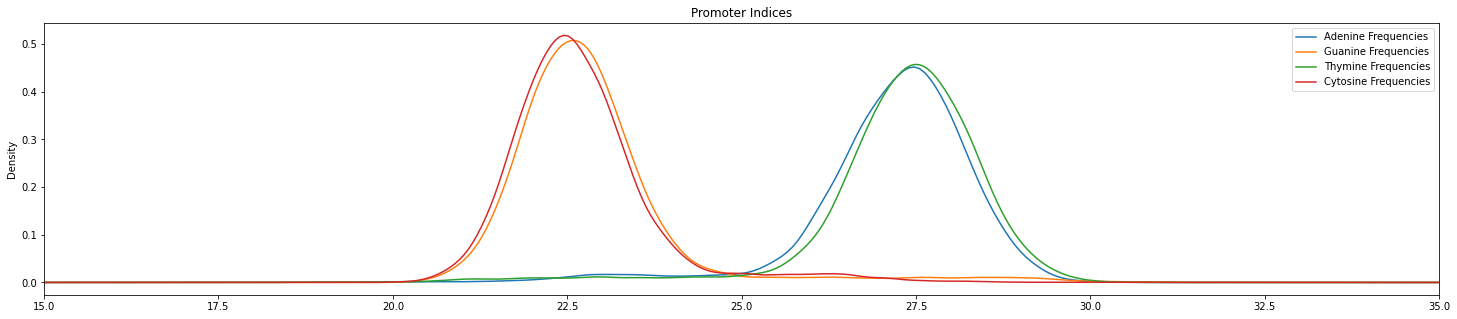

In [7]:
plt.figure()
frequency_df.plot.density(figsize = (25, 5), title = 'Promoter Indices', xlim = (15, 35))

## Preview the dataframe

In [8]:
dna_df.head(n = 20)

,Promoter-Index,One Hot Sequence
0,78,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, ..."
1,236,"[0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ..."
2,109,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."
3,77,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."
4,208,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
5,69,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
6,58,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, ..."
7,158,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."
8,136,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, ..."
9,156,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, ..."


## Preview the Negative Data set

In [9]:
neg_dna_df.head(n = 20)

,Promoter-Index,One Hot Sequence
0,x,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
1,x,"[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,x,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
3,x,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4,x,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
5,x,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
6,x,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
7,x,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
8,x,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
9,x,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."


## Comparison of Dataframe and Neg-Dataframe
* Verify the negative dataset was generated properly

In [10]:
# dna_df.compare(neg_dna_df)

# FREQUENCY DATAFRAME INFORMATION

---




## Printing frequency data frame

In [11]:
frequency_df.head(n=10500)

,Adenine Frequencies,Guanine Frequencies,Thymine Frequencies,Cytosine Frequencies
0,26.980676,22.850242,27.439614,22.729469
1,27.270531,21.618357,28.840580,22.270531
2,29.106280,22.391304,26.859903,21.642512
3,27.318841,23.526570,27.246377,21.908213
4,27.270531,22.342995,27.777778,22.608696
...,...,...,...,...
10495,23.574879,26.328502,25.362319,24.734300
10496,25.652174,26.473430,23.671498,24.202899
10497,24.396135,27.028986,23.429952,25.144928
10498,24.565217,25.772947,24.396135,25.265700


## Describing Frequency data frame

In [12]:
frequency_df.describe()

,Adenine Frequencies,Guanine Frequencies,Thymine Frequencies,Cytosine Frequencies
count,16000.000000,16000.000000,16000.000000,16000.000000
mean,27.152754,22.859567,27.289521,22.698158
std,1.239472,1.319228,1.281605,1.083547
min,12.584541,11.207729,9.830918,16.473430
25%,26.690821,22.149758,26.859903,22.053140
50%,27.318841,22.657005,27.439614,22.560386
75%,27.874396,23.188406,28.019324,23.091787
max,50.483092,35.483092,40.845411,47.487923


# SUBSEQUENCE DATAFRAME INFORMATION

---



## Printing Subsequence DataFrame

In [13]:
subsequence_df.head(n=20)

,Sub-Sequences,Promoter-Index,SequenceStart,SequenceEnd
0,"(T, C, C, C, A, C, A, T, C, G, A, C, A, A, G, ...",78,9922,10222
1,"(C, A, G, C, A, C, G, G, C, T, C, T, G, T, T, ...",236,9764,10064
2,"(T, T, A, T, A, G, T, T, A, T, T, T, A, G, T, ...",109,9891,10191
3,"(T, G, A, T, A, T, T, A, T, T, T, T, A, T, G, ...",77,9923,10223
4,"(C, T, C, A, C, T, C, A, T, A, C, T, A, A, C, ...",208,9792,10092
5,"(T, T, T, A, G, A, A, A, A, C, T, T, A, T, T, ...",69,9931,10231
6,"(A, A, T, C, C, A, A, A, A, A, A, T, A, T, A, ...",58,9942,10242
7,"(C, A, A, A, G, A, T, C, A, T, A, T, A, T, A, ...",158,9842,10142
8,"(A, A, T, G, T, C, A, A, A, A, C, C, A, A, C, ...",136,9864,10164
9,"(T, A, T, C, T, G, T, A, T, G, T, C, C, A, T, ...",156,9844,10144


## Describing the subsequence dataframe

In [14]:
print('Index frequencies:')
print(subsequence_df['Promoter-Index'].value_counts())

Index frequencies:
197    33
250    32
208    31
115    31
155    31
       ..
212    12
235    12
214    12
59     10
237     7
Name: Promoter-Index, Length: 200, dtype: int64


## Density plot of subsequence dataframe

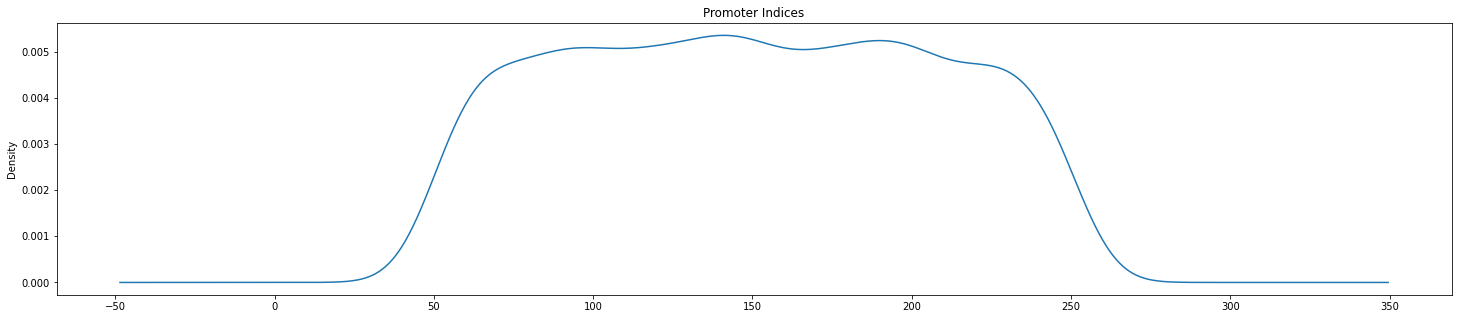

In [15]:
plt.figure()
subsequence_df['Promoter-Index'].plot.density(figsize = (25, 5), title = 'Promoter Indices')

# Arranging features and labels

In [16]:
X = dna_df.loc[:, 'One Hot Sequence'].to_numpy()
y = dna_df.loc[:, 'Promoter-Index'].to_numpy()

X_train = np.zeros((X.shape[0], 300, 4))
for i in range(X.shape[0]):
    (X_train[i, 0:300, 0], X_train[i, 0:300, 1], X_train[i, 0:300, 2], X_train[i, 0:300, 3]) = (X[i][3:1200:4], X[i][2:1200:4], X[i][1:1200:4], X[i][0:1200:4])

X_neg = neg_dna_df.loc[:, 'One Hot Sequence'].to_numpy()

X_train_neg = np.zeros((X_neg.shape[0], 300, 4))
for i in range(X_neg.shape[0]):
    (X_train_neg[i, 0:300, 0], X_train_neg[i, 0:300, 1], X_train_neg[i, 0:300, 2], X_train_neg[i, 0:300, 3]) = (X_neg[i][3:1200:4], X_neg[i][2:1200:4], X_neg[i][1:1200:4], X_neg[i][0:1200:4])

X_train

array([[[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]],

       [[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.]],

       [[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.]],

       ...,

       [[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]],

       [[0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]],

       [[0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 1.

## Constructing PyTorch Dataset

In [17]:
# import torch
# from torch.utils.data import Dataset, random_split

# class Sequences(Dataset):
#     def __init__(self, X, y):
#         self.sequences = torch.from_numpy(X) # convert numpy arrays to torch tensors
#         self.sequences = self.sequences.type(torch.float)
#         self.sequences = self.sequences.unsqueeze(1) # add extra dimension for torch

#         self.labels = torch.from_numpy(y)
#         self.labels = self.labels.type(torch.float)
#         self.labels = self.labels.unsqueeze(1)

#     def __len__(self):
#         assert len(self.sequences) == len(self.labels) # ensure 1-to-1 correspondence
#         return len(self.labels)

#     def __getitem__(self, i):
#         return self.sequences[i], self.labels[i] # return X, y pair

# Xt = X.reshape(-1,  1, 1200)
# data = Sequences(Xt, y)
# trainCount = int(0.8 * len(data)) # percent of our data for train
# train, test = random_split(data, [trainCount, len(data) - trainCount])
# train[0]

# Model Construction

### General Idea:
* Input
  * a sequence of 300 base pairs
* Next section:
  * Multiple Parallel Convolutional Layers
* Next section: 
  * BiLSTM
* Final section:
  * Fully-Connected Dense Net for promoter location prediction

### Detailed Idea:
* Input
  * a sequence of 300 base pairs
* Convolutional section:
  * 5 Convolutional layers (stacked atop each other)
    * 3 with window/kernel size: 27, 14, 7 respectively.
    * 2 with window/kernel size: 27, 14 respectively.
  * All Convolutional layers are followed by: 
    * ReLU activation function
    * Max pooling layer with window size = 6
    * Dropout layer with p = 0.5
* BiLSTM section:
  * 32 nodes 
* Flatten section
  * With dropout with p = 0.5
* Fully-connected section:
  * 2 fully-connected layers for classification:
    * first layer has 128 nodes
      * with by ReLU activations
      * dropout with p = 0.5
    * second layer has 1 node
      * with sigmoid activation

# Optimizer
* Adam optimizer
  * lr = 0.001
  * batch size = 32
  * epochs = 50
  * **EARLY STOPPING APPLIED ON VALIDATION LOSS**



In [18]:
# import torch.nn as nn
# import torch.nn.functional as F

# cnn_out_channels = 16 

# class HideAndSeq(nn.Module):
#   def __init__(self):
#       super().__init__()
#       # define the 5 parallel convolutional layers section
#       # TATA section
#       self.conv1 = nn.Conv1d(in_channels=1, out_channels=cnn_out_channels, kernel_size=27)
#       self.conv3 = nn.Conv1d(in_channels=1, out_channels=cnn_out_channels, kernel_size=14)
#       self.conv5 = nn.Conv1d(in_channels=1, out_channels=cnn_out_channels, kernel_size=7)

#       # Non-TATA section
#       self.conv2 = nn.Conv1d(in_channels=1, out_channels=cnn_out_channels, kernel_size=27)
#       self.conv4 = nn.Conv1d(in_channels=1, out_channels=cnn_out_channels, kernel_size=14)

#       # define layers following all conv layers
#       self.pool = nn.MaxPool1d(kernel_size=6)
#       self.dropout = nn.Dropout(p=0.5)
      
#       # define the BiLSTM section
#       self.LSTM = nn.LSTM(983, 1, 32, bidirectional=True)

#       # define fully connected layer
#       self.fully128 = nn.Linear(32, 128)

#       self.output = nn.Linear(128, 1)


#   def forward(self, x):
#     # apply ReLU activation and max pooling
#     x1 = self.dropout(self.pool(F.relu(self.conv1(x))))
#     x2 = self.dropout(self.pool(F.relu(self.conv2(x))))
#     x3 = self.dropout(self.pool(F.relu(self.conv3(x))))
#     x4 = self.dropout(self.pool(F.relu(self.conv4(x))))
#     x5 = self.dropout(self.pool(F.relu(self.conv5(x))))

#     # concatenate the convolutional outputs
#     cat = torch.cat([x1, x2, x3, x4, x5], 2)

#     # pass concatentation through LSTM with 32 recurrent cells/nodes
#     BiLSTM = self.LSTM(cat)

#     # define the flatten section
#     # consider using global average pooling instead of flatten
#     BiLSTM_output, _ = BiLSTM
#     flatten = torch.flatten(BiLSTM_output)

#     # define fully connected layers
#     fully = self.dropout(F.relu(self.fully128(flatten)))

#     # define output layer
#     out = torch.sigmoid(self.output(fully))

#     return out

# Help for starting training loop
* https://stackoverflow.com/questions/59584457/pytorch-is-there-a-definitive-training-loop-similar-to-keras-fit

In [19]:
# import time

# def fit(model, optimizer, loss_fn, train_dl, val_dl, epochs = 20, device = 'cuda'):
#     '''
#     Runs training loop for classification problems. Returns Keras-style
#     per-epoch history of loss and accuracy over training and validation data.

#     Parameters
#     ----------
#     model : nn.Module
#         Neural network model
#     optimizer : torch.optim.Optimizer
#         Search space optimizer (e.g. Adam)
#     loss_fn :
#         Loss function (e.g. nn.CrossEntropyLoss())
#     train_dl : 
#         Iterable dataloader for training data.
#     val_dl :
#         Iterable dataloader for validation data.
#     epochs : int
#         Number of epochs to run
#     device : string
#         Specifies 'cuda' or 'cpu'

#     Returns
#     -------
#     Dictionary
#         Similar to Keras' fit(), the output dictionary contains per-epoch
#         history of training loss, training accuracy, validation loss, and
#         validation accuracy.
#     '''

#     print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
#           (type(model).__name__, type(optimizer).__name__,
#            optimizer.param_groups[0]['lr'], epochs, device))

#     history = {} # Collects per-epoch loss and acc like Keras' fit().
#     history['loss'] = []
#     history['val_loss'] = []
#     history['acc'] = []
#     history['val_acc'] = []

#     start_time_sec = time.time()

#     for epoch in range(epochs):

#         # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
#         model.train()
#         train_loss         = 0.0
#         num_train_correct  = 0
#         num_train_examples = 0

#         for batch in train_dl:

#             optimizer.zero_grad()

#             x    = batch[0].to(device)
#             y    = batch[1].to(device)
#             yhat = model(x)
#             print('y is', y)
#             loss = loss_fn(yhat, y)

#             loss.backward()
#             optimizer.step()

#             train_loss         += loss.data.item() * x.size(0)
#             num_train_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
#             num_train_examples += x.shape[0]

#         train_acc   = num_train_correct / num_train_examples
#         train_loss  = train_loss / len(train_dl.dataset)


#         # --- EVALUATE ON VALIDATION SET -------------------------------------
#         model.eval()
#         val_loss         = 0.0
#         num_val_correct  = 0
#         num_val_examples = 0

#         for batch in val_dl:

#             x    = batch[0].to(device)
#             y    = batch[1].to(device)
#             yhat = model(x)
#             loss = loss_fn(yhat, y)
#             print('batch', batch)

#             val_loss         += loss.data.item() * x.size(0)
#             num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
#             num_val_examples += y.shape[0]

#         val_acc  = num_val_correct / num_val_examples
#         val_loss = val_loss / len(val_dl.dataset)


#         print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
#               (epoch+1, epochs, train_loss, train_acc, val_loss, val_acc))

#         history['loss'].append(train_loss)
#         history['val_loss'].append(val_loss)
#         history['acc'].append(train_acc)
#         history['val_acc'].append(val_acc)

#     # END OF TRAINING LOOP


#     end_time_sec       = time.time()
#     total_time_sec     = end_time_sec - start_time_sec
#     time_per_epoch_sec = total_time_sec / epochs
#     print('Time total:     %5.2f sec' % (total_time_sec))
#     print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

#     return history

In [20]:
# model = HideAndSeq()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# loss_fn = nn.CrossEntropyLoss()
# batch_size = 32

# print('type of train', type(train))
# print('length of train', len(train[0]))
# # print('batch is ', )

# fit(model, optimizer, loss_fn, train, test, device = 'cpu')

#Keras model

##Setting up the data

In [21]:
np.random.seed(0)
X_bin_pos = np.copy(X_train)
y_bin_pos = np.ones(y.shape[0])

X_bin_neg = np.copy(X_train_neg)
y_bin_neg = np.zeros(X_bin_neg.shape[0])

m_bin_pos, m_bin_neg = (X_bin_pos.shape[0], X_bin_neg.shape[0])
m_bin_sys = m_bin_pos + m_bin_neg
X_bin_sys = np.concatenate((X_bin_pos, X_bin_neg))
y_bin_sys = np.concatenate((y_bin_pos, y_bin_neg))

indices = np.random.permutation(np.arange(m_bin_sys))
first = math.floor(m_bin_sys * .8)
train_indices, test_indices = indices[:first], indices[first:]

X_bin_train, X_bin_test = (X_bin_sys[train_indices], X_bin_sys[test_indices])
y_bin_train, y_bin_test = (y_bin_sys[train_indices], y_bin_sys[test_indices])

##Constructing the model

In [27]:
import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout

input_shape = (300, 4)

inputs = tf.keras.Input(shape=input_shape)
x1 = Conv1D(256, 27,  activation = 'relu')(inputs)
x1 = MaxPooling1D(6)(x1)
# x1 = Dropout(0.5)(x1)

x2 = Conv1D(256, 14,  activation = 'relu')(inputs)
x2 = MaxPooling1D(6)(x2)
# x2 = Dropout(0.5)(x2)

x3 = Conv1D(256, 7,   activation = 'relu')(inputs)
x3 = MaxPooling1D(6)(x3)
# x3 = Dropout(0.5)(x3)

x4 = Conv1D(256, 27,  activation = 'relu')(inputs)
x4 = MaxPooling1D(6)(x4)
# x4 = Dropout(0.5)(x4)

x5 = Conv1D(256, 14,  activation = 'relu')(inputs)
x5 = MaxPooling1D(6)(x5)
# x5 = Dropout(0.5)(x5)

x = K.layers.concatenate([x1, x2, x3, x4, x5], axis=1)

BiLSTM_output = K.layers.Bidirectional(K.layers.LSTM(32))(x)

f = K.layers.Flatten()(BiLSTM_output)

d1 = K.layers.Dense(128, activation = 'relu')(f)
outputs = K.layers.Dense(1, activation = 'softmax')(d1)

model = K.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 4)]          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 274, 256)          27904     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 45, 256)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 32, 128)           458880    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5, 32)             28704     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 1, 32)             0   

##Compiling the model

In [30]:
# y_ohe = K.utils.to_categorical(y, num_classes = 300)

opt = K.optimizers.Adam(learning_rate=.001)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

##Fitting the model

In [31]:
model.fit(X_bin_train, y_bin_train, batch_size = 32, epochs = 50, verbose = 1, validation_split = .2)

Epoch 1/50
166/166 [==============================] - 2s 8ms/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6934 - val_accuracy: 0.4921
Epoch 2/50
166/166 [==============================] - 1s 6ms/step - loss: 0.6931 - accuracy: 0.5010 - val_loss: 0.6933 - val_accuracy: 0.4921
Epoch 3/50
166/166 [==============================] - 1s 6ms/step - loss: 0.6931 - accuracy: 0.5010 - val_loss: 0.6933 - val_accuracy: 0.4921
Epoch 4/50
166/166 [==============================] - 1s 6ms/step - loss: 0.6930 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.4921
Epoch 5/50
166/166 [==============================] - 1s 6ms/step - loss: 0.6931 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.4921
Epoch 6/50
166/166 [==============================] - 1s 6ms/step - loss: 0.6931 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.4921
Epoch 7/50
166/166 [==============================] - 1s 6ms/step - loss: 0.6931 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.4921
Epoch 

In [25]:
y_hat = model.predict(X_train_neg)

In [26]:
y_hat

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)